### TOC

https://www.kaggle.com/datasets/mexwell/heart-disease-dataset

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import functools
import json
import matplotlib.pyplot as plt
import itertools
import os
import re
import pickle
import joblib
import json
import pathlib
import typing as t
import datetime
import tqdm.notebook as tqdm
import dataclasses
import ipdb
import warnings
import pickle
import logging
import copy
import math
import pprint

In [3]:
import sklearn
import sklearn.metrics

In [4]:
import IPython.display 

In [5]:
warnings.filterwarnings(action='ignore', category=UserWarning)

In [6]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [7]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 80
plt.rcParams['figure.max_open_warning'] = 100
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.constrained_layout.use'] = False
plt.rcParams['savefig.dpi'] = 80

In [8]:
# https://matplotlib.org/stable/tutorials/introductory/usage.html#what-is-interactive-mode
plt.ioff();

In [9]:
%load_ext tensorboard

# dataset

In [10]:
df = pd.read_csv('data/heart_statlog_cleveland_hungary_final.csv.gz', sep=',', low_memory=False)

In [11]:
df.sample(10)

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
521,64,1,4,130,223,0,1,128,0,0.5,2,0
80,55,1,3,110,277,0,0,160,0,0.0,1,0
305,51,1,4,95,0,1,0,126,0,2.2,2,1
1108,54,0,3,108,267,0,2,167,0,0.0,1,0
1091,43,1,4,110,211,0,0,161,0,0.0,1,0
408,62,1,4,115,0,1,0,72,1,-0.5,2,1
1025,35,1,4,120,198,0,0,130,1,1.6,2,1
1079,43,1,4,132,247,1,2,143,1,0.1,2,1
513,35,1,3,123,161,0,1,153,0,-0.1,1,0
317,57,1,3,105,0,1,0,148,0,0.3,2,1


In [12]:
df.dtypes

age                      int64
sex                      int64
chest pain type          int64
resting bp s             int64
cholesterol              int64
fasting blood sugar      int64
resting ecg              int64
max heart rate           int64
exercise angina          int64
oldpeak                float64
ST slope                 int64
target                   int64
dtype: object

In [13]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1190.0,53.720168,9.358203,28.0,47.0,54.0,60.00,77.0
sex,1190.0,0.763866,0.424884,0.0,1.0,1.0,1.00,1.0
chest pain type,1190.0,3.232773,0.935480,1.0,3.0,4.0,4.00,4.0
resting bp s,1190.0,132.153782,18.368823,0.0,120.0,130.0,140.00,200.0
cholesterol,1190.0,210.363866,101.420489,0.0,188.0,229.0,269.75,603.0
fasting blood sugar,1190.0,0.213445,0.409912,0.0,0.0,0.0,0.00,1.0
resting ecg,1190.0,0.698319,0.870359,0.0,0.0,0.0,2.00,2.0
max heart rate,1190.0,139.732773,25.517636,60.0,121.0,140.5,160.00,202.0
exercise angina,1190.0,0.387395,0.487360,0.0,0.0,0.0,1.00,1.0
oldpeak,1190.0,0.922773,1.086337,-2.6,0.0,0.6,1.60,6.2


# split to train and set

In [14]:
df_trn, df_tst = sklearn.model_selection.train_test_split(df, test_size=0.2, random_state=42, stratify=df['target'])

In [15]:
len(df_trn)

952

In [16]:
len(df_tst)

238

# model

In [17]:
import torch
import torch.nn
import torch.nn.utils.rnn
import torch.nn.init
import torch.cuda
import torch.utils.data
import torch.optim
import torch.optim.lr_scheduler
import torch.utils.tensorboard

## event dataset

In [18]:
@dataclasses.dataclass(frozen=True)
class SampleRow:
    
    data: pd.Series

In [19]:
@dataclasses.dataclass(frozen=True)
class SampleBatch:

    size: int

    features: torch.FloatTensor
    
    targets: torch.FloatTensor

In [20]:
class SampleDataset(torch.utils.data.Dataset):

    FEATURES: t.List[str] = [
        'age', 'sex', 'chest pain type', 'resting bp s', 
        'cholesterol', 'fasting blood sugar', 'resting ecg', 'max heart rate', 
        'exercise angina', 'oldpeak', 'ST slope',
    ]
    
    def __init__(self, df: pd.DataFrame, device: torch.device):
        super(SampleDataset).__init__()

        self.df = df
        self.device = device

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int) -> SampleRow:
        return SampleRow(data=self.df.iloc[idx])

    def loader(self, batch_size: int = 1024) -> torch.utils.data.DataLoader:
        return torch.utils.data.DataLoader(self, batch_size=batch_size, shuffle=True, collate_fn=self.collate)

    def load(self, 
             batch_size: int = 1024, 
             title: str = 'procesing', 
            ) -> t.Iterator[SampleBatch]:
        loader: torch.utils.data.DataLoader = self.loader(batch_size)

        with tqdm.tqdm(total=len(self.df), desc=title, mininterval=30, maxinterval=120, delay=20) as pbar:
            for batch in loader:
                yield batch

                pbar.update(batch.size)
        
    def collate(self, batch: t.List[SampleRow]) -> SampleBatch:
        features: t.List[t.List[float]] = [row.data[self.FEATURES].astype(float).values for row in batch]
        targets: t.List[float] = [float(row.data['target']) for row in batch]

        # convert sample bean into a map of tensors
        return SampleBatch(
            size=len(batch),
            features=torch.FloatTensor(features).to(self.device),
            targets=torch.FloatTensor(targets).to(self.device),
        )

## dataset example

In [21]:
example_dataset = SampleDataset(df, device=torch.device('cpu:0'))

In [22]:
example_dataloader = example_dataset.loader(batch_size=5)

In [23]:
example_batch = next(iter(example_dataloader))

In [24]:
pprint.pprint(example_batch, indent=4, width=120)

SampleBatch(size=5,
            features=tensor([[ 62.0000,   0.0000,   4.0000, 150.0000, 244.0000,   0.0000,   0.0000,
         154.0000,   1.0000,   1.4000,   2.0000],
        [ 37.0000,   1.0000,   3.0000, 130.0000, 194.0000,   0.0000,   0.0000,
         150.0000,   0.0000,   0.0000,   1.0000],
        [ 46.0000,   1.0000,   4.0000, 110.0000, 202.0000,   0.0000,   0.0000,
         150.0000,   1.0000,   0.0000,   2.0000],
        [ 41.0000,   1.0000,   4.0000, 110.0000, 289.0000,   0.0000,   0.0000,
         170.0000,   0.0000,   0.0000,   2.0000],
        [ 51.0000,   1.0000,   2.0000, 130.0000, 224.0000,   0.0000,   0.0000,
         150.0000,   0.0000,   0.0000,   1.0000]]),
            targets=tensor([1., 0., 1., 1., 0.]))


## event model

In [25]:
class SampleModel(torch.nn.Module):

    DIMENSION_INPUT = len(SampleDataset.FEATURES)

    DIMENSION_HIDDEN_1 = 128

    DIMENSION_HIDDEN_2 = 64

    DIMENSION_HIDDEN_3 = 8

    DIMENSION_OUTPUT = 1

    def __init__(self):
        super(SampleModel, self).__init__()

        # hidden layers
        self.fc = torch.nn.Sequential(
            # fc layers
            self.make_fc_layer(self.DIMENSION_INPUT,    self.DIMENSION_HIDDEN_1),
            self.make_fc_layer(self.DIMENSION_HIDDEN_1, self.DIMENSION_HIDDEN_2),
            self.make_fc_layer(self.DIMENSION_HIDDEN_2, self.DIMENSION_HIDDEN_3),
            # output
            self.make_linear_layer(self.DIMENSION_HIDDEN_3, self.DIMENSION_OUTPUT),
        )

    @classmethod
    def make_fc_layer(cls, in_size: int, out_size: int) -> torch.nn.Module: 
        return torch.nn.Sequential(
            cls.make_linear_layer(in_size, out_size),
            torch.nn.BatchNorm1d(out_size),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(0.5),
        )
    
    @classmethod
    def make_linear_layer(cls, in_size: int, out_size: int) -> torch.nn.Module: 
        layer: torch.nn.Module = torch.nn.Linear(in_size, out_size)
        torch.nn.init.xavier_uniform_(layer.weight)
        torch.nn.init.zeros_(layer.bias)
        return layer        
        
    def forward(self, batch: SampleBatch) -> torch.Tensor:
        return self.fc(batch.features)

In [26]:
class SampleModelManager:

    BATCH_SIZE: int = 256

    LR_STEP: float = 0.95

    def __init__(self, device: torch.device = torch.device('cpu'), lr: float = 0.001):
        self.model: SampleModel = SampleModel()
        self.model.to(device)

        if device.type == 'cuda':
            if torch.cuda.get_device_properties(device.index).multi_processor_count >= 80:
                self.model.compile()
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=self.LR_STEP)
        
        self.criterion = torch.nn.BCEWithLogitsLoss()

        self.trn_dataset: SampleDataset = SampleDataset(df_trn, device=device)
        self.tst_dataset: SampleDataset = SampleDataset(df_tst, device=device)
        
        self.tag_time: datetime.datetime = datetime.datetime.now()
        self.tag_name: str = self.tag_time.strftime("%Y%m%d-%H%M%S")
        
        self.summary = torch.utils.tensorboard.SummaryWriter(log_dir=f'runs/{self.tag_name}', flush_secs=30)

        self.train_epoch = 0
        self.train_step = 0
    
    def train(self):
        self.model.train()

        batches: t.Iterator[SampleBatch] = self.trn_dataset.load(
            batch_size=self.BATCH_SIZE,
            title='training',
        )

        for batch in batches:
            outputs = self.model(batch)

            self.optimizer.zero_grad()

            loss = self.criterion(outputs[:, 0], batch.targets)
            loss.backward()

            self.optimizer.step()

            self.train_step += batch.size

            self.summary.add_scalars('loss', {'trn': loss.item()}, self.train_step)
        
    def loss(self, dataset: SampleDataset) -> float:
        self.model.eval()

        batches: t.Iterator[SampleBatch] = dataset.load(
            batch_size=self.BATCH_SIZE, 
            title='testing',
        )

        dataset_loss: float = 0.0
        dataset_rows: int = 0        

        with torch.no_grad():
            for batch in batches:
                outputs = self.model(batch)
                
                loss = self.criterion(outputs[:, 0], batch.targets)
                
                dataset_loss += loss.item() * batch.size
                dataset_rows += batch.size

        return dataset_loss / dataset_rows

    def sample(self, limit: int) -> t.Tuple[t.List[float], t.List[float]]:
        self.model.eval()

        actual: t.List[float] = []
        predicted: t.List[float] = []

        batches: t.Iterator[SampleBatch] = self.tst_dataset.loader(batch_size=self.BATCH_SIZE)
        
        with torch.no_grad():
            for batch in batches:
                outputs = self.model(batch)
                classes = torch.sigmoid(outputs[:, 0])

                actual.extend(batch.targets.cpu().numpy())
                predicted.extend(classes.cpu().numpy())

                if len(actual) >= limit:
                    break

        return actual[:limit], predicted[:limit]
    
    def loop(self, epochs: int):
        for i in range(epochs):
            print('start of epoch {} with lr={}'.format(self.train_epoch, self.scheduler.get_last_lr()))
            
            self.train() 
            self.scheduler.step()
            
            trn_loss: float = self.loss(self.trn_dataset)
            tst_loss: float = self.loss(self.tst_dataset)
            print('epoch: {:d}, step: {:d}, train: {:.3f}, test: {:.3f}'.format(self.train_epoch, self.train_step, trn_loss, tst_loss))

            self.summary.add_scalars('loss', {'epoch_trn': trn_loss, 'epoch_tst': tst_loss}, self.train_step)
            self.summary.flush()

            self.train_epoch += 1

    def save(self, path: str):
        state = self.model.state_dict()
        torch.save(state, path)

    def load(self, path: str):
        state = torch.load(path, weights_only=True)
        self.model.load_state_dict(state)

# train

In [27]:
torch.cuda.is_available()

True

In [28]:
torch.cuda.get_device_capability()

(8, 9)

In [29]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA RTX 3500 Ada Generation Laptop GPU', major=8, minor=9, total_memory=12002MB, multi_processor_count=40, uuid=96c349c6-7ea5-f8c7-3628-7cd40658958e, L2_cache_size=48MB)

In [30]:
device = torch.device('cuda:0')

In [31]:
device

device(type='cuda', index=0)

In [32]:
manager = SampleModelManager(lr=0.05, device=device)

In [33]:
manager.model

SampleModel(
  (fc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=11, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.5, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.5, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=64, out_features=8, bias=True)
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.5, inplace=False)
    )
    (3): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [34]:
manager.loop(epochs=100)

start of epoch 0 with lr=[0.05]
epoch: 0, step: 952, train: 4.452, test: 4.229
start of epoch 1 with lr=[0.0475]
epoch: 1, step: 1904, train: 1.070, test: 0.910
start of epoch 2 with lr=[0.045125]
epoch: 2, step: 2856, train: 0.752, test: 0.656
start of epoch 3 with lr=[0.04286875]
epoch: 3, step: 3808, train: 0.872, test: 0.769
start of epoch 4 with lr=[0.04072531249999999]
epoch: 4, step: 4760, train: 0.690, test: 0.647
start of epoch 5 with lr=[0.038689046874999994]
epoch: 5, step: 5712, train: 0.806, test: 0.770
start of epoch 6 with lr=[0.03675459453124999]
epoch: 6, step: 6664, train: 0.693, test: 0.666
start of epoch 7 with lr=[0.03491686480468749]
epoch: 7, step: 7616, train: 1.089, test: 1.070
start of epoch 8 with lr=[0.03317102156445311]
epoch: 8, step: 8568, train: 0.781, test: 0.764
start of epoch 9 with lr=[0.03151247048623045]
epoch: 9, step: 9520, train: 0.771, test: 0.747
start of epoch 10 with lr=[0.02993684696191893]
epoch: 10, step: 10472, train: 0.698, test: 0.662


In [35]:
manager.save('data/model.pth')

# tensorboard

In [36]:
%tensorboard --logdir runs

# test

In [37]:
manager_test = SampleModelManager()

In [38]:
manager_test.load('data/model.pth')

In [39]:
actual, predicted = manager_test.sample(10000)

In [40]:
actual[:4]

[1.0, 1.0, 1.0, 0.0]

In [41]:
predicted[:4]

[0.7575333, 0.9180608, 0.94102657, 0.10143855]

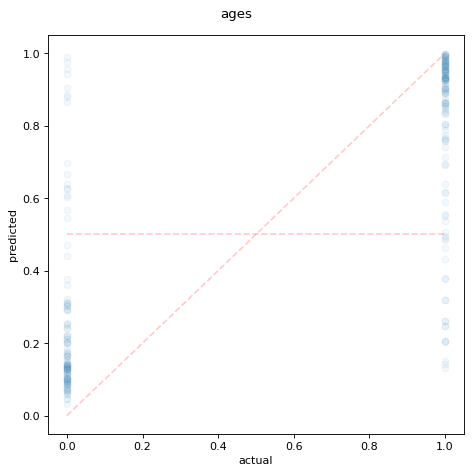

In [42]:
fig, ax = plt.subplots(1, 1, squeeze=True, figsize=(6, 6))

ax.scatter(actual, predicted, alpha=0.05)

ax.plot([0.0, 1.0], [0.0, 1.0], linestyle='--', color='r', alpha=0.2)
ax.plot([0.0, 1.0], [0.5, 0.5], linestyle='--', color='r', alpha=0.2)

ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])

ax.set_xlabel('actual')
ax.set_ylabel('predicted')

fig.suptitle('ages')
fig.tight_layout()
fig

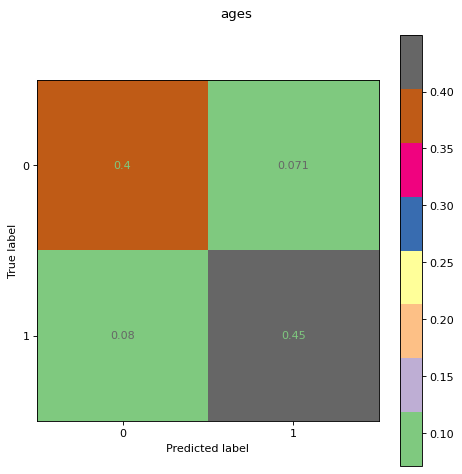

In [43]:
fig, ax = plt.subplots(1, 1, squeeze=True, figsize=(6, 6))

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
    [int(label >= 0.5) for label in actual], 
    [int(label >= 0.5) for label in predicted],
    ax=ax, normalize='all', cmap='Accent'
)

fig.suptitle('ages')
fig.tight_layout()
fig